In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime
import ta

In [3]:
# Ticker list: 30 NIFTY stocks + 4 ETFs
nifty_30 = [
    'RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS',
    'LT.NS', 'SBIN.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'HCLTECH.NS',
    'ITC.NS', 'ASIANPAINT.NS', 'ULTRACEMCO.NS', 'NESTLEIND.NS', 'HINDUNILVR.NS',
    'BAJFINANCE.NS', 'ADANIENT.NS', 'POWERGRID.NS', 'COALINDIA.NS', 'BHARTIARTL.NS',
    'NTPC.NS', 'TITAN.NS', 'ONGC.NS', 'SUNPHARMA.NS', 'TECHM.NS',
    'DIVISLAB.NS', 'WIPRO.NS', 'MARUTI.NS', 'TATAMOTORS.NS', 'BPCL.NS'
]

tickers = nifty_30

In [4]:
def compute_features(df_price, df_volume):
    df = pd.DataFrame(index=df_price.index)

    # Returns
    df["log_ret_1d"] = np.log(df_price / df_price.shift(1))
    df["log_ret_5d"] = np.log(df_price / df_price.shift(5))

    # Volatility
    df["vol_5d"] = df["log_ret_1d"].rolling(5).std()
    df["vol_20d"] = df["log_ret_1d"].rolling(20).std()

    # RSI
    df["rsi_14"] = ta.momentum.RSIIndicator(close=df_price, window=14).rsi()

    # Moving Averages
    df["ma_5d"] = df_price.rolling(5).mean()
    df["ma_20d"] = df_price.rolling(20).mean()

    # MACD
    macd = ta.trend.MACD(close=df_price)
    df["macd_diff"] = macd.macd_diff()

    # Volume change
    df["vol_chg"] = df_volume.pct_change()

    # Final cleanup
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Instead of dropping all rows, fill them
    df.fillna(method="ffill", inplace=True)   # forward fill
    df.fillna(method="bfill", inplace=True)   # back fill if needed
    df.fillna(0, inplace=True)                # fallback to 0 if any remain

    return df

In [5]:
all_features = []

for ticker in tickers:
    df = yf.download(ticker, start="2018-01-01", end="2024-12-31", auto_adjust=True)
    price = df['Close'].squeeze()    # Ensures shape (n,)
    volume = df['Volume'].squeeze()

    features = compute_features(price, volume)
    features = features.add_prefix(f"{ticker}_")
    all_features.append(features)   

[*********************100%***********************]  1 of 1 completed
/var/folders/r_/cwd775rd0td5_q92qnzfdwt80000gn/T/ipykernel_52179/3360669154.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)   # forward fill
/var/folders/r_/cwd775rd0td5_q92qnzfdwt80000gn/T/ipykernel_52179/3360669154.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)   # back fill if needed
[*********************100%***********************]  1 of 1 completed
/var/folders/r_/cwd775rd0td5_q92qnzfdwt80000gn/T/ipykernel_52179/3360669154.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)   # forward fill
/var/folders/r_/cwd77

In [6]:
market_snapshot = pd.concat(all_features, axis=1).dropna()
market_snapshot.shape

(1726, 270)

In [7]:
prices = yf.download(tickers, start="2018-01-01", end="2024-12-31", auto_adjust=True)["Close"]

future_returns = pd.DataFrame(index=prices.index)

for ticker in prices.columns:
    try:
        future_price = prices[ticker].shift(-5)
        future_returns[ticker] = ((future_price - prices[ticker]) / prices[ticker])  # simple return
    except Exception as e:
        print(f"Error in {ticker}: {e}")


[*********************100%***********************]  30 of 30 completed


In [8]:
# Align and merge on date index
nf = market_snapshot.join(future_returns, how='inner')
nf.shape

(1726, 300)

In [9]:
future_returns.isna().sum()

ADANIENT.NS      5
ASIANPAINT.NS    5
AXISBANK.NS      5
BAJFINANCE.NS    5
BHARTIARTL.NS    5
BPCL.NS          5
COALINDIA.NS     5
DIVISLAB.NS      5
HCLTECH.NS       5
HDFCBANK.NS      5
HINDUNILVR.NS    5
ICICIBANK.NS     5
INFY.NS          5
ITC.NS           5
KOTAKBANK.NS     5
LT.NS            5
MARUTI.NS        5
NESTLEIND.NS     5
NTPC.NS          5
ONGC.NS          5
POWERGRID.NS     5
RELIANCE.NS      5
SBIN.NS          5
SUNPHARMA.NS     5
TATAMOTORS.NS    5
TCS.NS           5
TECHM.NS         5
TITAN.NS         5
ULTRACEMCO.NS    5
WIPRO.NS         5
dtype: int64

In [10]:
nf = nf.dropna()
nf.shape

(1721, 300)

In [11]:
X = nf[market_snapshot.columns]
y = nf[future_returns.columns]

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler

# Optional: Scale the features (LGBM doesn't need it, but helps other models)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultiOutputRegressor(LGBMRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
mae_scores = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
rmse_scores = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))

for i, ticker in enumerate(y.columns):
    print(f"{ticker} → R²: {r2_scores[i]:.3f} | MAE: {mae_scores[i]:.5f} | RMSE: {rmse_scores[i]:.5f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68850
[LightGBM] [Info] Number of data points in the train set: 1376, number of used features: 270
[LightGBM] [Info] Start training from score 0.013113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68850
[LightGBM] [Info] Number of data points in the train set: 1376, number of used features: 270
[LightGBM] [Info] Start training from score 0.002710
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68850
[LightGBM] [Info] Number of data points in the train set: 1376, number of used features: 270
[LightGBM] [Info] Start 

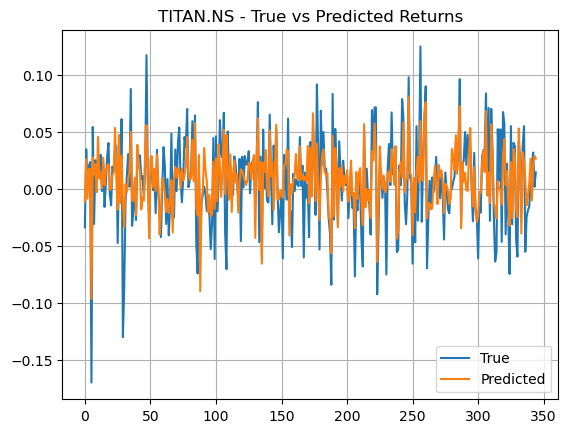

In [14]:
import matplotlib.pyplot as plt

stock = "TITAN.NS"
plt.plot(y_test[stock].values, label="True")
plt.plot(y_pred[:, y.columns.get_loc(stock)], label="Predicted")
plt.title(f"{stock} - True vs Predicted Returns")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Score on training set
y_train_pred = model.predict(X_train)

train_r2 = r2_score(y_train, y_train_pred, multioutput='raw_values')
test_r2 = r2_score(y_test, y_pred, multioutput='raw_values')

for i, ticker in enumerate(y.columns):
    print(f"{ticker} → Train R²: {train_r2[i]:.3f} | Test R²: {test_r2[i]:.3f}")

ADANIENT.NS → Train R²: 0.975 | Test R²: 0.456
ASIANPAINT.NS → Train R²: 0.991 | Test R²: 0.548
AXISBANK.NS → Train R²: 0.976 | Test R²: 0.383
BAJFINANCE.NS → Train R²: 0.982 | Test R²: 0.603
BHARTIARTL.NS → Train R²: 0.989 | Test R²: 0.558
BPCL.NS → Train R²: 0.984 | Test R²: 0.475
COALINDIA.NS → Train R²: 0.993 | Test R²: 0.557
DIVISLAB.NS → Train R²: 0.987 | Test R²: 0.534
HCLTECH.NS → Train R²: 0.986 | Test R²: 0.525
HDFCBANK.NS → Train R²: 0.982 | Test R²: 0.484
HINDUNILVR.NS → Train R²: 0.985 | Test R²: 0.528
ICICIBANK.NS → Train R²: 0.982 | Test R²: 0.466
INFY.NS → Train R²: 0.986 | Test R²: 0.581
ITC.NS → Train R²: 0.988 | Test R²: 0.591
KOTAKBANK.NS → Train R²: 0.980 | Test R²: 0.638
LT.NS → Train R²: 0.986 | Test R²: 0.525
MARUTI.NS → Train R²: 0.980 | Test R²: 0.533
NESTLEIND.NS → Train R²: 0.981 | Test R²: 0.538
NTPC.NS → Train R²: 0.990 | Test R²: 0.580
ONGC.NS → Train R²: 0.981 | Test R²: 0.586
POWERGRID.NS → Train R²: 0.986 | Test R²: 0.580
RELIANCE.NS → Train R²: 0.989 